In [3]:
%load_ext autoreload
%autoreload 1


In [27]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
import warnings
import seaborn as sns

from computage.utils.data_utils import download_meta, download_dataset
from computage.utils.nan_utils import EN_nan_row_predict,introduce_nans

from computage.models_library.model import LinearMethylationModel

import pandas as pd
import gzip

# loading + preprocessing

In [5]:
# data = pd.read_csv('full_blood_HC.csv')
# data
import os
import glob

#import reader
from multiprocessing import Pool

def read_psv_all (file_name):
    return pd.read_csv(file_name,
                       #delimiter='',  # change this as needed                              
                       low_memory=False, index_col = ['Unnamed: 0']
                      ) 

pool = Pool(processes=3) # can change 3 to number of processors you want to utilize
data = read_psv_all('full_blood_HC.csv')
data.head()

,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg27356438,cg27409364,cg27425675,cg27443050,cg27460755,cg27476329,cg27513764,cg27530424,cg27585441,cg27657249
GSM1443658,0.850345,0.571662,0.115101,0.217371,0.136810,0.699549,0.747217,0.107723,0.766730,0.813303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443800,0.821636,0.506415,0.138980,0.212379,0.090243,0.586473,0.747264,0.233739,0.792255,0.808847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443272,0.802247,0.518845,0.151033,0.288431,0.107367,0.618184,0.795986,0.129477,0.735356,0.828617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443250,0.851498,0.601998,0.104490,0.188970,0.107187,0.731727,0.749568,0.221319,0.778124,0.832554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443266,0.824495,0.608025,0.108236,0.192101,0.097375,0.556048,0.714904,0.249572,0.767942,0.806314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(1079, 487177)

In [7]:
meta = pd.read_csv('full_blood_HC_meta.csv',index_col = ['Unnamed: 0'])
meta.shape

(1079, 59)

In [8]:
meta

,Unnamed: 0.1,Title,Tissue,CellType,Gender,Age,Condition,_ConditionSubtype,Platform,SourceGSE,...,_DNAmAge,Condition_SmokingStatus,Ethnicity,_BrodmannArea,_H_in,_W_lb,_ConditionAnemia,_SmokingStatus,_AlcoholStatus,_TcellsES
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GSM1443250,0,NaN,Blood,Whole blood,F,79.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443266,1,NaN,Blood,Whole blood,F,90.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443272,2,NaN,Blood,Whole blood,M,78.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443658,3,NaN,Blood,Whole blood,F,84.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443796,4,NaN,Blood,Whole blood,M,76.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1354388,334,101247,Blood,CD14+,NaN,52.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011649
GSM1354392,335,101251,Blood,CD14+,NaN,45.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025156
GSM1354399,336,101258,Blood,CD14+,NaN,55.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000217


In [9]:
y = pd.DataFrame(meta['Age'])
y = y.rename(columns={'Age': 'age'})
y

,age
Unnamed: 0,
GSM1443250,79.0
GSM1443266,90.0
GSM1443272,78.0
GSM1443658,84.0
GSM1443796,76.0
...,...
GSM1354388,52.0
GSM1354392,45.0
GSM1354399,55.0


In [10]:
y.isna().sum()

age    1
dtype: int64

In [11]:
y[y['age'].isnull()].index.tolist()

['GSM796696']

In [12]:
data.loc['GSM796696']

cg13869341    0.85448
cg14008030    0.50837
cg12045430    0.07106
cg20826792    0.14338
cg00381604    0.05724
               ...   
cg27476329        NaN
cg27513764        NaN
cg27530424        NaN
cg27585441        NaN
cg27657249        NaN
Name: GSM796696, Length: 487177, dtype: float64

In [13]:

data = data.drop(y[y['age'].isnull()].index.tolist())
y = y.dropna()

In [14]:
meta[meta['Condition']!='HC']
# в этом датасете все здоровые

,Unnamed: 0.1,Title,Tissue,CellType,Gender,Age,Condition,_ConditionSubtype,Platform,SourceGSE,...,_DNAmAge,Condition_SmokingStatus,Ethnicity,_BrodmannArea,_H_in,_W_lb,_ConditionAnemia,_SmokingStatus,_AlcoholStatus,_TcellsES
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,


In [33]:
len(nan_pct)

19

In [55]:
percents = list(map(lambda element:str(round(element*100)), nan_pct))

In [56]:
nan_pct = np.linspace(0, 0.9, 19)
def medae_r2(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y

    mae_uie = []
    r2_uie = []
    

    for p in nan_pct:
        X_nan = introduce_nans(X_test, p)
        #X_nan = X_nas
        y_pred_test = model.predict(X_nan)
        
        
        
        mae_uie.append(median_absolute_error(y_test, y_pred_test))
        r2_uie.append(r2_score(y_test, y_pred_test))
    return mae_uie, r2_uie  

def medae_r2_pred(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y

    mae_uie = []
    r2_uie = []

    pred_list = []

    for p in nan_pct:
        X_nan = introduce_nans(X_test, p)
        #X_nan = X_nas
        y_pred_test = model.predict(X_nan)
        
        
        pred_list.append(y_pred_test)
        mae_uie.append(median_absolute_error(y_test, y_pred_test))
        r2_uie.append(r2_score(y_test, y_pred_test))
    pred_matrix = pd.concat(pred_list, axis=1)
    pred_matrix.columns=percents

    return mae_uie, r2_uie, pred_matrix 

In [57]:
mname="PhenoAge2018"
model_1 = LinearMethylationModel(name=mname)
modelX_w = data.reindex(columns=model_1.features)
percent_missing = modelX_w.isnull().sum().sum() / (modelX_w.shape[0]*modelX_w.shape[1])
print(f'already missed = {round(percent_missing,2)} percent')

mae_0, r2_0, pred0 = medae_r2_pred(data, y, model_1)
mae_avg, r2_avg, predavg = medae_r2_pred(data, y, LinearMethylationModel(name=mname, imputation='average'))
mae_ses, r2_ses, predses = medae_r2_pred(data, y, LinearMethylationModel(name=mname, imputation="sesame_450k"))
#'sesame_450k'

already missed = 0.0 percent


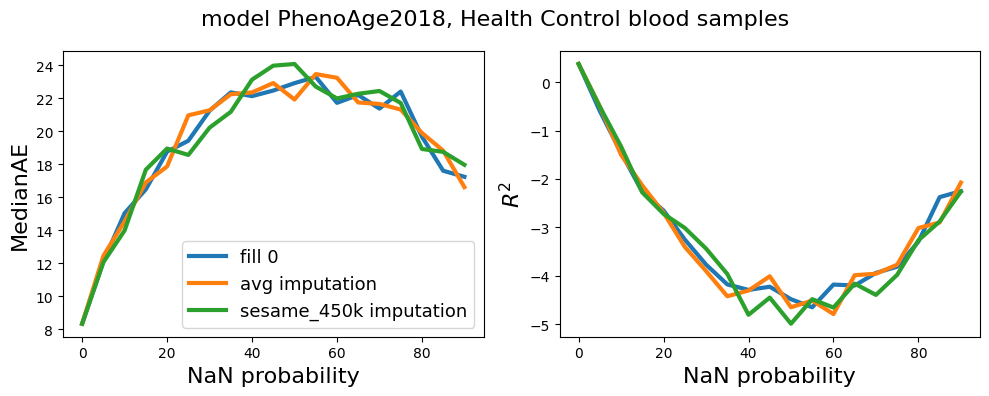

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'model {mname}, Health Control blood samples', fontsize=16)
ax[0].plot(nan_pct*100, mae_0, lw=3, label='fill 0')
ax[0].plot(nan_pct*100, mae_avg, lw =3, label = 'avg imputation')
ax[0].plot(nan_pct*100, mae_ses, lw =3, label = 'sesame_450k imputation')
ax[1].plot(nan_pct*100, r2_0, lw=3)
ax[1].plot(nan_pct*100, r2_avg, lw = 3)
ax[1].plot(nan_pct*100, r2_ses, lw = 3)


ax[0].set_xlabel('NaN probability', fontsize=16)
ax[1].set_xlabel('NaN probability', fontsize=16)
ax[0].set_ylabel('MedianAE', fontsize=16)
ax[1].set_ylabel('$R^2$', fontsize=16)
ax[0].legend(fontsize=13)
#ax[1].set_ylim([-0.5, 1.0])
plt.tight_layout()

plt.savefig(f'figures/{mname}.png')
plt.show()

In [58]:
pred0

,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90
GSM1443658,68.384659,54.959354,35.926774,49.621768,75.210984,84.477377,35.365663,23.997448,47.650344,76.221462,56.991881,75.607767,35.912430,60.706502,79.319408,78.812757,50.296057,36.200978,55.974798
GSM1443800,71.624863,64.209079,99.287119,63.010197,67.961773,60.521235,49.080250,89.093815,115.611452,56.002593,106.317220,101.348488,35.176225,31.605851,18.990823,50.836723,88.532866,57.298028,41.785570
GSM1443272,74.193826,92.904137,74.412323,105.382937,78.570137,31.879335,75.022155,96.371704,50.412697,8.974790,71.742359,82.870583,65.416092,15.659020,-10.983520,104.750092,55.577501,37.899630,55.214579
GSM1443250,69.468992,55.322603,66.832915,82.288184,79.749774,98.963320,67.475295,60.600417,94.475157,92.906791,36.730281,85.072756,97.312453,73.431959,43.461897,88.736360,58.089225,62.914065,39.153630
GSM1443266,69.290751,75.963392,87.716920,65.154826,108.345629,22.546196,46.044890,74.747836,56.044754,24.208640,89.520558,105.650776,68.639743,109.696085,84.873052,-7.617018,78.456914,92.678306,69.616467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1354388,66.319520,111.090654,73.517807,40.585053,83.977387,41.242950,41.427348,28.994564,69.684710,34.422765,55.857617,93.621567,24.882975,100.426671,85.485393,62.619515,65.029265,90.797427,52.782943
GSM1354392,60.034890,67.386192,51.155994,64.344977,25.151178,66.507043,91.291488,69.638155,102.863322,74.442476,117.288417,49.283567,46.652155,39.755225,26.806067,37.083051,73.364486,26.223625,26.389945
GSM1354399,61.891068,48.313975,87.099238,89.794970,37.937494,96.552511,30.494911,13.686691,18.853418,91.134745,69.061448,95.626039,24.992309,37.173496,36.550711,49.758466,60.262529,73.385716,73.315483
GSM1354400,59.135157,73.239859,95.733116,60.170104,84.134958,31.752796,46.610216,36.046343,59.870961,115.883822,20.955200,83.604645,121.508971,68.770404,63.090030,65.692712,69.967583,43.824288,22.979177


In [59]:
predavg

,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90
GSM1443658,68.384659,62.924592,71.857539,58.805920,83.034976,54.751781,84.459675,44.043718,-0.394345,36.958431,86.845082,69.626554,52.128968,35.442432,28.671394,35.970155,69.329969,67.339684,60.697482
GSM1443800,71.624863,55.851415,51.008920,33.100878,58.117959,80.087559,50.396237,41.331233,79.178795,-25.168979,69.993683,72.583366,81.480431,45.439272,-1.483467,48.611090,69.799664,66.033615,85.307672
GSM1443272,74.193826,61.708013,66.214492,63.304695,49.540935,83.590519,49.015003,103.119960,127.666030,93.607384,105.360640,103.256519,118.217741,106.238909,8.459375,94.585220,86.621821,101.909338,75.849421
GSM1443250,69.468992,101.420552,80.619280,49.056354,82.297506,22.365318,67.389101,57.802232,21.301288,116.360466,34.872548,33.629168,104.363099,79.006535,53.849638,58.335874,8.885510,75.069340,89.983466
GSM1443266,69.290751,59.947275,88.104541,71.447466,76.081843,7.379683,90.107841,38.048036,96.949228,48.085965,52.018196,-4.124232,60.671256,12.276595,63.075828,81.261807,87.456201,63.944130,40.656783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1354388,66.319520,42.819856,80.519575,73.466014,30.832585,43.852836,95.042578,48.242217,103.725756,37.355265,111.792246,47.485481,104.521882,66.488186,81.157123,37.996839,65.397639,69.872212,82.027361
GSM1354392,60.034890,84.899025,70.998050,33.514246,26.749823,63.566622,82.442192,101.437396,56.289444,64.279215,6.196460,28.690082,44.790040,90.019660,23.028394,59.454870,14.630768,25.344191,54.068884
GSM1354399,61.891068,56.535231,75.851144,46.148063,55.330288,53.695682,56.941664,12.313492,89.837159,39.453800,41.919409,54.247997,102.415214,92.275139,55.009388,100.349043,94.598270,81.900419,74.151855
GSM1354400,59.135157,38.959969,24.365630,63.268488,60.941715,71.728742,54.104347,62.323494,58.936621,124.476670,11.060377,76.721278,68.315020,70.095409,42.838268,11.807788,45.112415,68.462212,53.850943


In [60]:
predses

,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90
GSM1443658,68.384659,62.000282,74.938052,74.082348,80.488266,53.789573,59.645917,78.593774,75.760634,105.605107,86.600576,25.940253,70.023964,84.057416,96.920705,16.848797,69.004087,86.211646,40.798766
GSM1443800,71.624863,60.717574,58.231709,46.031116,33.949864,11.308798,98.628920,-3.431041,43.777630,71.854301,31.899137,42.551906,96.886626,33.197412,34.508100,40.432841,63.074752,63.609278,87.719558
GSM1443272,74.193826,86.065175,77.188276,90.071083,38.866427,67.644778,53.003821,36.605376,75.892033,36.044956,48.483996,36.452814,66.686289,55.671196,73.011208,86.571414,92.096518,51.780405,75.777976
GSM1443250,69.468992,66.288657,28.698251,71.794272,64.206966,65.303330,94.736640,76.975991,88.215552,35.091526,42.550967,18.807973,37.211150,62.073257,96.430774,58.963843,45.950149,70.990963,54.909667
GSM1443266,69.290751,75.215344,107.897580,48.099907,72.699555,47.146606,71.346525,108.398065,53.209606,64.572011,64.113812,21.799329,-12.781398,64.527146,43.554892,38.494181,80.766626,41.024591,46.666917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1354388,66.319520,61.549911,53.359018,95.609808,71.005790,81.721753,52.696635,84.667644,38.152306,108.771555,112.605001,81.934066,80.235252,79.823877,132.058257,85.974724,84.985208,58.728813,41.071739
GSM1354392,60.034890,52.584914,68.301159,57.832271,57.899016,88.404420,81.782958,46.628550,88.432037,47.530291,70.126337,9.588216,67.572278,49.303013,29.764787,38.969745,69.336876,40.426106,79.480920
GSM1354399,61.891068,37.768521,61.457159,65.236293,81.848153,22.008035,79.359692,-6.627619,71.435121,25.342138,50.546572,96.839026,32.721484,85.661040,74.782427,44.585689,78.673101,59.244106,53.391420
GSM1354400,59.135157,65.684602,42.368553,58.860915,100.188118,28.363039,95.891676,78.593901,39.500528,114.019640,34.100382,71.357656,39.618792,55.961685,70.919185,39.853131,68.183875,109.443976,44.756693


In [ ]:
imputdf = pd.DataFrame()



df = pd.DataFrame({'X_Axis':[1,3,5,7,10,20],
                   'col_2':[.4,.5,.4,.5,.5,.4],
                   'col_3':[.7,.8,.9,.4,.2,.3],
                   'col_4':[.1,.3,.5,.7,.1,.0],
                   'col_5':[.5,.3,.6,.9,.2,.4]})

# display(df)
   X_Axis  col_2  col_3  col_4  col_5
0       1    0.4    0.7    0.1    0.5
1       3    0.5    0.8    0.3    0.3
2       5    0.4    0.9    0.5    0.6
3       7    0.5    0.4    0.7    0.9
4      10    0.5    0.2    0.1    0.2
5      20    0.4    0.3    0.0    0.4

# convert to long (tidy) form
dfm = df.melt('X_Axis', var_name='cols', value_name='vals')


In [42]:
np.random.seed(2022)  # to produce the same data each time
df = pd.DataFrame({"trial" : np.random.randint(10, size=350),
                   "rvalues" : np.random.randn(350),
                   "subject" : np.random.randint(4, size=350)})
df

,trial,rvalues,subject
0,0,0.837976,1
1,1,-1.422107,3
2,1,-0.670349,3
3,0,-0.290743,1
4,7,0.498557,1
...,...,...,...
345,8,-1.036710,0
346,6,0.922003,0
347,8,0.795781,3
348,4,0.578973,3


In [62]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.lineplot( data=pred0.transpose(), err_style="band", ci='sd', estimator="median")

/tmp/ipykernel_1574822/1101882046.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot( data=pred0.transpose(), err_style="band", ci='sd', estimator="median")


<Axes: >

Error in callback <function flush_figures at 0x7f55f9b91c60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
sns.lineplot(x="trial", y="rvalues", hue="subject", err_style="band",
             errorbar ='sd',
             estimator=np.median,
             data=df)